/home/mattylev/.pyenv/versions/3.12.6/envs/simplex/lib/python3.12/site-packages/jaxtyping/__init__.py:231: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(


Moving model to device:  cuda
Discovered 1 top-k fits and 1 vanilla fit(s).
Collected 60000 latent rows for layer_1_top_12
Collected 60000 latent rows for layer_1_vanilla_lambda0.1


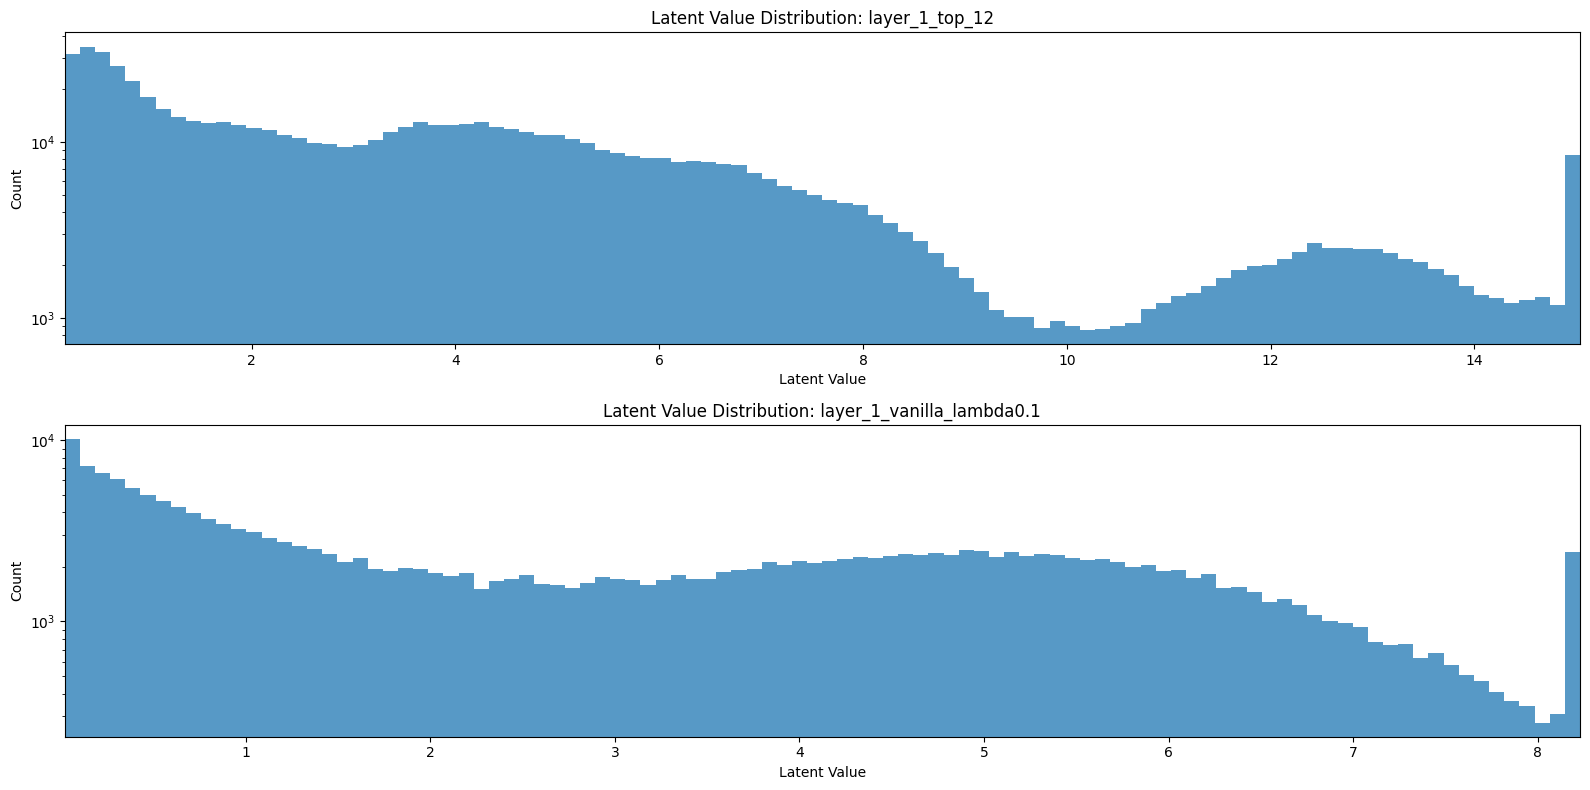

In [1]:

import os
import sys
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, ROOT_DIR)
os.environ.setdefault("JAX_PLATFORM_NAME", "cpu")


import math
from types import SimpleNamespace

import torch
import numpy as np
import matplotlib.pyplot as plt
import jax

from transformer_lens import HookedTransformer, HookedTransformerConfig
from BatchTopK.sae import TopKSAE, VanillaSAE
from multipartite_utils import MultipartiteSampler, _load_process_stack

# Paths / experiment settings
PROCESS_CONFIG = os.path.join(ROOT_DIR, "process_configs.json")
PROCESS_CONFIG_NAME = "3xmess3_2xtquant_003"
MODEL_CKPT = os.path.join(ROOT_DIR, "outputs/checkpoints/multipartite_003/checkpoint_step_6000_best.pt")
SAE_DIR = os.path.join(ROOT_DIR, "outputs/saes/multipartite_003e")
SITE_MODE = "layer"
LAYER_IDX = 1
SITE_PREFIX = "embeddings" if SITE_MODE == "embeddings" else f"layer_{LAYER_IDX}"

# Analysis hyperparameters
K = 12
LAMBDA = 0.1
N_SEQUENCES = 4000
BATCH_SIZE = 128
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 0


def parse_fit_filename(fn: str, site_prefix: str):
    if not fn.endswith('.pt'):
        return (None, None, None)
    prefix = f"{site_prefix}_"
    if not fn.startswith(prefix):
        return (None, None, None)
    remainder = fn[len(prefix):-len('.pt')]
    if remainder.startswith('top_k_k'):
        try:
            idx = int(remainder[len('top_k_k'):])
        except ValueError:
            return (None, None, None)
        return ('top', idx, None)
    if remainder.startswith('vanilla_lambda_'):
        try:
            lam = float(remainder[len('vanilla_lambda_'):])
        except ValueError:
            return (None, None, None)
        return ('vanilla', None, lam)
    return (None, None, None)

def build_sampler(process_config: str, config_name: str):
    args = SimpleNamespace(
        process_config=process_config,
        process_config_name=config_name,
        process_preset=None,
    )
    process_cfg_raw, components, data_source = _load_process_stack(args, {})
    if isinstance(data_source, MultipartiteSampler):
        return data_source
    return MultipartiteSampler(components)


def load_transformer(ckpt_path: str, device: str):
    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
    cfg_dict = ckpt.get("config")
    if isinstance(cfg_dict, dict):
        cfg = HookedTransformerConfig.from_dict(cfg_dict)
    else:
        cfg = HookedTransformerConfig(
            d_model=128,
            n_heads=4,
            n_layers=3,
            n_ctx=16,
            d_vocab=432,
            d_head=32,
            act_fn="relu",
            device=device,
        )
    model = HookedTransformer(cfg).to(device)
    state = ckpt.get("state_dict") or ckpt.get("model_state_dict")
    if state is None:
        raise ValueError("Checkpoint missing state_dict")
    model.load_state_dict(state, strict=False)
    model.eval()
    return model, cfg


def load_sae(path: str, sae_type: str):
    checkpoint = torch.load(path, map_location=DEVICE)
    cfg = checkpoint.get("cfg")
    if cfg is None:
        raise ValueError(f"Missing cfg in {path}")
    cfg = dict(cfg)
    cfg["device"] = DEVICE
    cfg["dtype"] = torch.float32
    state = checkpoint.get("state_dict") or checkpoint
    sae_cls = TopKSAE if sae_type == "top" else VanillaSAE
    sae = sae_cls(cfg).to(DEVICE)
    sae.load_state_dict(state)
    sae.eval()
    return sae


sampler = build_sampler(PROCESS_CONFIG, PROCESS_CONFIG_NAME)
model, model_cfg = load_transformer(MODEL_CKPT, DEVICE)
hook_name = "hook_embed" if SITE_MODE == "embeddings" else f"blocks.{LAYER_IDX}.hook_resid_post"
seq_len = int(model_cfg.n_ctx)

fits = []
for fn in os.listdir(SAE_DIR):
    tag, idx, lambd = parse_fit_filename(fn, SITE_PREFIX)
    if tag == "top" and idx is not None and np.isclose(idx, K):
        fits.append(("top", idx, os.path.join(SAE_DIR, fn)))
    elif tag == "vanilla" and lambd is not None and np.isclose(lambd, LAMBDA):
        fits.append(("vanilla", None, os.path.join(SAE_DIR, fn)))

fit_top = sorted([f for f in fits if f[0] == "top"], key=lambda x: x[1])[:K]
fit_vanilla = [f for f in fits if f[0] == "vanilla"]
fits_for_analysis = fit_top + fit_vanilla
print(f"Discovered {len(fit_top)} top-k fits and {len(fit_vanilla)} vanilla fit(s).")

rng_key = jax.random.PRNGKey(SEED)

def sample_activations(batch_size: int):
    global rng_key
    rng_key, _, product_tokens, _ = sampler.sample(rng_key, batch_size, seq_len)
    tokens = torch.from_numpy(np.array(product_tokens)).long().to(DEVICE)
    with torch.no_grad():
        _, cache = model.run_with_cache(tokens, names_filter=[hook_name])
    acts = cache[hook_name].reshape(-1, cache[hook_name].shape[-1]).detach()
    return acts

all_latents = {}
for fit_type, idx, path in fits_for_analysis:
    sae = load_sae(path, fit_type)
    latents_chunks = []
    sequences_remaining = N_SEQUENCES
    while sequences_remaining > 0:
        cur_batch = min(BATCH_SIZE, sequences_remaining)
        acts = sample_activations(cur_batch)
        with torch.no_grad():
            sae_out = sae(acts)
            feats = sae_out.get("feature_acts")
            if feats is None:
                raise RuntimeError("SAE output missing feature_acts")
            latents_chunks.append(feats.detach().cpu().numpy())
        sequences_remaining -= cur_batch
    latents = np.concatenate(latents_chunks, axis=0)
    key = f"{SITE_PREFIX}_{fit_type}_{idx if idx is not None else f'lambda{LAMBDA}'}"
    all_latents[key] = latents
    print(f"Collected {latents.shape[0]} latent rows for {key}")

plt.figure(figsize=(16, 4 * len(all_latents)))
for plt_idx, (name, latents) in enumerate(all_latents.items()):
    plt.subplot(len(all_latents), 1, plt_idx + 1)
    data = latents.flatten()
    active_mask = np.abs(data) > 1e-9
    if active_mask.sum() == 0:
        ax = plt.gca()
        ax.text(0.5, 0.5, "No active latents", transform=ax.transAxes,
                ha="center", va="center", color="red", fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])
        continue
    active = data[active_mask]
    lo, hi = np.percentile(active, [1, 99])
    if np.isclose(lo, hi):
        delta = max(abs(lo) * 0.05, 1e-6)
        lo -= delta
        hi += delta
    hist_data = np.clip(active, lo, hi)
    plt.hist(hist_data, bins=100, range=(lo, hi), alpha=0.75, color='C0')
    plt.xlim(lo, hi)
    plt.yscale('log')
    plt.title(f"Latent Value Distribution: {name}")
    plt.xlabel("Latent Value")
    plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(SAE_DIR, "latent_histograms.png"))
plt.show()

np.savez_compressed(os.path.join(SAE_DIR, "all_latents.npz"), **all_latents)

/tmp/ipykernel_1117561/4105818691.py:21: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(lo, hi)


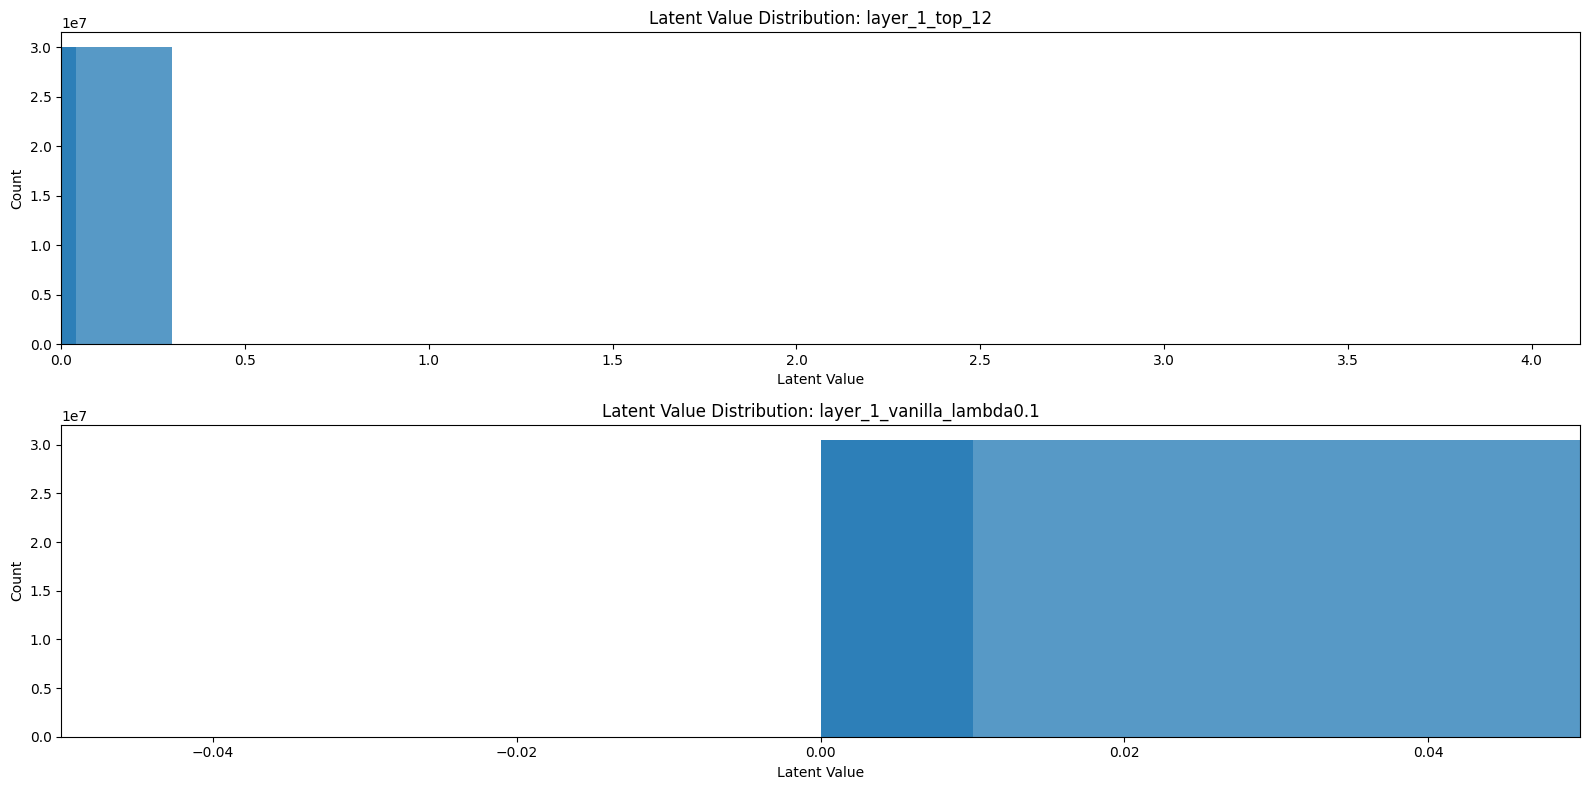

In [3]:

plt.figure(figsize=(16, 4 * len(all_latents)))
for plt_idx, (name, latents) in enumerate(all_latents.items()):
    plt.subplot(len(all_latents), 1, plt_idx + 1)
    data = latents.flatten()
    active = data[np.abs(data) > 1e-9]
    if active.size == 0:
        plt.text(0.5, 0.5, "No active latents", transform=plt.gca().transAxes,
                 ha="center", va="center", color="red")
        continue
    magnitude_limit = np.percentile(np.abs(active), 99)
    magnitude_limit = max(magnitude_limit, 1e-6)
    clipped = np.clip(data, -magnitude_limit, magnitude_limit)
    plt.hist(clipped, bins=100, range=(-magnitude_limit, magnitude_limit), alpha=0.75, color='C0')
    plt.xlim(-magnitude_limit, magnitude_limit)
    if data.size == 0:
        continue
    hi = np.percentile(data, 99)
    lo = np.percentile(data, 1)
    clipped = data[(data >= lo) & (data <= hi)]
    plt.hist(clipped, bins=100, alpha=0.75, color='C0')
    plt.xlim(lo, hi)
    plt.title(f"Latent Value Distribution: {name}")
    plt.xlabel("Latent Value")
    plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(SAE_DIR, "latent_histograms.png"))
plt.show()

np.savez_compressed(os.path.join(SAE_DIR, "all_latents.npz"), **all_latents)